In [158]:
import pandas as pd
import numpy as np
import plotly.express as px

columns = [
        # 'join_id',
        'dt','chain', 'active_secs_per_day'
        ,'num_l1_txs_inbox','num_l1_txs_output','calldata_bytes_l1_inbox'
        ,'avg_l1_gas_price_on_l1_inbox','avg_l1_gas_price_on_l1_output','avg_l1_gas_price_on_l2'
        ,'l1_gas_used_inbox','l1_gas_used_output','l1_gas_used_combined'
        ,'l1_eth_fees_inbox','l1_eth_fees_output','l1_eth_fees_combined'
        ,'l1_contrib_l2_eth_fees_per_day','l2_contrib_l2_eth_fees_per_day'
        # ,'l2_num_raw_txs_per_day'
        ,'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
        ,'l1_gas_used_on_l2','calldata_bytes_l2_per_day','calldata_gas_l2_per_day'
        ,'l1_gas_used_user_txs_l2_per_day','calldata_bytes_user_txs_l2_per_day', 'calldata_gas_user_txs_l2_per_day'
        ,'l2_gas_used','l2_gas_used_user_txs_per_day','l2_eth_fees_per_day'
        ,'avg_l2_base_fee_gwei', 'avg_l2_gas_price_gwei'
        ]

In [159]:
#Unify datasets
dunedf = pd.read_csv('csv_inputs/op_chain_gas_economics_dune_query_2453515_dt2023_09_20_180day.csv') #https://dune.com/queries/2453515 --last 90 days
# goldskydf = pd.read_csv('csv_inputs/op_chain_gas_economics_goldsky_zora_pgn_dt2023_09_12.csv') #requires auth - https://dash.goldsky.com/question/9-op-chains-activity-by-period

In [160]:
# Map Chain Names
chain_mappings = {
    'zora': 'Zora Network',
    'pgn': 'Public Goods Network',
    # Add more mappings as needed
}
# goldskydf['chain'] = goldskydf['chain'].replace(chain_mappings)
dunedf['name'] = dunedf['name'].replace(chain_mappings)
dunedf['avg_l2_priority_fee_gwei'] = dunedf['avg_l2_gas_price_gwei'] - dunedf['avg_l2_base_fee_gwei']
dunedf['eth_fees_margin_per_day'] = dunedf['l2_eth_fees_per_day'] - dunedf['l1_eth_fees_combined']
# print(dunedf.columns)

added_cols = ['avg_l2_priority_fee_gwei','eth_fees_margin_per_day']

In [161]:
#Configure
#rename cols
dunedf = dunedf.rename(columns={
                        'name':'chain'
                        })
difference = set(columns) - set(dunedf.columns)
result = list(difference)

print(result)


[]


In [162]:
#Generate Join ID Column
# dunedf['join_id'] = dunedf['dt'].astype(str).str[:10].str.cat(dunedf['chain'].astype(str).str.lower())
# goldskydf['join_id'] = goldskydf['dt'].astype(str).str[:10].str.cat(goldskydf['chain'].astype(str).str.lower())

# display(dunedf.head(10))
# print(dunedf.columns)
# print('---')
# display(goldskydf.head(10))
# print(goldskydf.columns)

combo_df = dunedf.copy()#merge(goldskydf, on='join_id', how='left')

# display(combo_df)

# for c in columns:
#         try:
#                 combo_df[c] = combo_df[c+'_x'].combine_first(combo_df[c+'_y']) #pick first non-null
#         except:
#                 combo_df[c] = combo_df[c] #nada

combo_df['dt'] = pd.to_datetime(combo_df['dt'])
combo_df = combo_df[columns + added_cols]

combo_df['gas_compression_ratio'] = combo_df['l1_gas_used_inbox'] / combo_df['l1_gas_used_on_l2']
combo_df['bytes_compression_ratio'] = combo_df['calldata_bytes_l1_inbox'] / combo_df['calldata_bytes_l2_per_day']
combo_df['dt_rank'] = combo_df['dt'].rank(method='dense', ascending=False).astype('int')

In [163]:
display( combo_df.sample(5) )

combo_df.to_csv('outputs/op_chain_gas_economics_sample.csv')

,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,l1_gas_used_inbox,...,l2_gas_used,l2_gas_used_user_txs_per_day,l2_eth_fees_per_day,avg_l2_base_fee_gwei,avg_l2_gas_price_gwei,avg_l2_priority_fee_gwei,eth_fees_margin_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
36,2023-09-10 00:00:00+00:00,Base,86400.000,1462,24,90063416.000,9.732,9.664,9.672,1466979200.000,...,220709055222.000,218265945132.000,34.550,0.011,0.082,0.071,20.253,0.580,0.659,10
148,2023-08-13 00:00:00+00:00,Base,86400.000,1432,24,80615023.000,14.513,13.942,14.470,1316027488.000,...,107551203123.000,104836733266.000,71.622,0.000,0.479,0.479,52.493,0.610,0.553,38
297,2023-07-06 00:00:00+00:00,Base,NaN,1423,24,2040698.000,39.744,40.030,NaN,62318612.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
264,2023-07-15 00:00:00+00:00,OP Mainnet,86400.000,873,24,96042756.000,14.022,13.871,13.921,1550677332.000,...,142759957378.000,140485818521.000,31.281,0.000,0.047,0.047,9.508,0.597,0.429,67
58,2023-09-05 00:00:00+00:00,Zora Network,86400.000,166,24,12852612.000,17.508,17.238,17.329,208506360.000,...,14143539621.000,11858114438.000,7.961,0.000,0.365,0.365,4.275,0.679,0.434,15


In [164]:
bl_gas_ratio = combo_df['l1_gas_used_inbox'].sum() / combo_df['l1_gas_used_user_txs_l2_per_day'].sum()
bl_bytes_ratio = combo_df['calldata_bytes_l1_inbox'].sum() / combo_df['calldata_bytes_user_txs_l2_per_day'].sum()
print('Blended gas compression ratio: ' + str(round(bl_gas_ratio*100,1)) + '%')
print('Blended bytes compression ratio: ' + str(round(bl_bytes_ratio*100,1)) + '%')

Blended gas compression ratio: 62.4%
Blended bytes compression ratio: 52.3%


In [165]:
# Create the scatter plot
combo_df_plot = combo_df[
                        (~combo_df['gas_compression_ratio'].isna()) 
                         & (combo_df['gas_compression_ratio']<1) 
                         & (combo_df['active_secs_per_day'] == 86400)
                         ]

# combo_df_plot = combo_df[(~combo_df['bytes_compression_ratio'].isna())
#                          & (combo_df['active_secs_per_day'] == 86400)]

display(combo_df_plot)

fig = px.scatter(combo_df_plot,
                 x='calldata_gas_user_txs_l2_per_day',#'l1_gas_used_on_l2',
                 y='l1_gas_used_inbox',
                 size = 'l2_num_txs_per_day',
                 color='chain',
                 title='L1 Gas Used on each Layer by chain')

# Display the plot
fig.show()

##############

fig_bytes = px.scatter(combo_df_plot,
                 x='calldata_gas_user_txs_l2_per_day',#'calldata_bytes_l2_per_day',
                 y='calldata_bytes_l1_inbox',
                 size = 'l2_num_txs_per_day',
                 color='chain',
                 title='Calldata Bytes on each Layer by chain')

fig_bytes.show()

,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,l1_gas_used_inbox,...,l2_gas_used,l2_gas_used_user_txs_per_day,l2_eth_fees_per_day,avg_l2_base_fee_gwei,avg_l2_gas_price_gwei,avg_l2_priority_fee_gwei,eth_fees_margin_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
0,2023-09-19 00:00:00+00:00,Base,86400.000,1667,24,115969659.000,13.058,11.729,13.205,1884225924.000,...,220526908466.000,218118691922.000,49.795,0.010,0.082,0.072,25.166,0.533,0.645,1
1,2023-09-19 00:00:00+00:00,OP Mainnet,86400.000,561,24,64802808.000,12.478,11.373,12.321,1045714116.000,...,221022281924.000,218760297432.000,37.426,0.075,0.109,0.034,24.354,0.648,0.462,1
2,2023-09-19 00:00:00+00:00,Zora Network,86400.000,148,24,10626024.000,12.396,12.031,12.069,172625664.000,...,12063546566.000,9814224699.000,3.243,0.000,0.146,0.146,1.078,0.786,0.432,1
4,2023-09-18 00:00:00+00:00,Base,86400.000,1765,24,126965466.000,19.492,14.246,20.031,2061454812.000,...,220609018037.000,218193812029.000,93.364,0.093,0.175,0.081,53.153,0.511,0.653,2
5,2023-09-18 00:00:00+00:00,OP Mainnet,86400.000,546,24,62864270.000,15.981,15.227,15.549,1014412664.000,...,221129920290.000,218875988214.000,56.277,0.129,0.183,0.055,40.033,0.669,0.479,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,2023-06-11 00:00:00+00:00,OP Mainnet,86400.000,698,24,75076007.000,17.448,16.546,17.139,1212500696.000,...,147062759593.000,144831652119.000,29.801,0.000,0.042,0.042,8.610,0.600,0.425,101
368,2023-06-10 00:00:00+00:00,OP Mainnet,86400.000,761,24,82801904.000,25.358,22.331,24.694,1337026820.000,...,188565203605.000,186326674062.000,60.744,0.089,0.128,0.039,26.793,0.612,0.446,102
369,2023-06-09 00:00:00+00:00,OP Mainnet,86400.000,725,24,78404424.000,21.023,20.588,20.835,1266182916.000,...,132605852900.000,130380684935.000,32.679,0.000,0.023,0.023,6.017,0.609,0.443,103
370,2023-06-08 00:00:00+00:00,OP Mainnet,86400.000,680,24,72779082.000,24.181,23.096,23.896,1175500704.000,...,115494446053.000,113273351404.000,36.827,0.000,0.046,0.046,8.354,0.607,0.438,104


In [166]:
new_data = combo_df[combo_df['active_secs_per_day'] == 86400].copy()
display(new_data.sample(5))

,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,l1_gas_used_inbox,...,l2_gas_used,l2_gas_used_user_txs_per_day,l2_eth_fees_per_day,avg_l2_base_fee_gwei,avg_l2_gas_price_gwei,avg_l2_priority_fee_gwei,eth_fees_margin_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
199,2023-08-01 00:00:00+00:00,Public Goods Network,86400.000,146,24,1921307.000,22.606,21.983,25.790,33752732.000,...,2239388216.000,41733588.000,0.085,0.000,1.378,1.378,-0.724,21.738,0.168,50
101,2023-08-25 00:00:00+00:00,OP Mainnet,86400.000,573,24,66223249.000,22.568,22.448,22.410,1068660508.000,...,109221635064.000,106992873658.000,34.223,0.000,0.082,0.082,10.058,0.644,0.468,26
47,2023-09-08 00:00:00+00:00,Public Goods Network,86400.000,146,24,1883868.000,15.847,17.399,13.448,33155520.000,...,2200822554.000,24565107.000,0.016,0.000,0.509,0.509,-0.546,97.788,0.167,12
16,2023-09-15 00:00:00+00:00,Base,86400.000,1892,24,156632648.000,16.022,14.390,15.470,2537018852.000,...,220265629852.000,217765302332.000,93.474,0.063,0.185,0.122,52.796,0.504,0.717,5
308,2023-07-02 00:00:00+00:00,OP Mainnet,86400.000,750,24,82114135.000,14.863,14.339,14.728,1325948056.000,...,133767511927.000,131553246815.000,27.403,0.000,0.038,0.038,7.666,0.596,0.427,80


In [167]:
selected_columns = [
    'l2_num_txs_per_day' #, 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
    # , 'l1_gas_used_on_l2'
    , 'calldata_gas_l2_per_day'
    , 'calldata_bytes_l2_per_day'
    , 'l1_gas_used_user_txs_l2_per_day', 'calldata_bytes_user_txs_l2_per_day', 'calldata_gas_user_txs_l2_per_day'
    , 'l1_gas_used_inbox'
    , 'avg_l2_priority_fee_gwei', 'avg_l2_base_fee_gwei'
]

missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                    0
calldata_gas_l2_per_day               0
calldata_bytes_l2_per_day             0
l1_gas_used_user_txs_l2_per_day       0
calldata_bytes_user_txs_l2_per_day    0
calldata_gas_user_txs_l2_per_day      0
l1_gas_used_inbox                     0
avg_l2_priority_fee_gwei              3
avg_l2_base_fee_gwei                  3
dtype: int64

In [168]:
# Step 2: Feature Selection - Examining the correlation between the potential features and the target variable
correlation_matrix = new_data[selected_columns].corr()

# Getting the correlation of all features with the target variable 'l1_gas_used_inbox'
target_correlation = correlation_matrix['l1_gas_used_inbox']

# Displaying the correlation values
target_correlation

l2_num_txs_per_day                    0.914
calldata_gas_l2_per_day               0.975
calldata_bytes_l2_per_day             0.971
l1_gas_used_user_txs_l2_per_day       0.994
calldata_bytes_user_txs_l2_per_day    0.970
calldata_gas_user_txs_l2_per_day      0.975
l1_gas_used_inbox                     1.000
avg_l2_priority_fee_gwei             -0.364
avg_l2_base_fee_gwei                  0.301
Name: l1_gas_used_inbox, dtype: float64

In [169]:
# Filling the missing values in 'l1_gas_used_on_l2' with 0
# new_data['l1_gas_used_on_l2'].fillna(0, inplace=True)
new_data['calldata_gas_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_bytes_l2_per_day'].fillna(0, inplace=True)
new_data['l1_gas_used_user_txs_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_bytes_user_txs_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_gas_user_txs_l2_per_day'].fillna(0, inplace=True)


# Verifying that there are no more missing values in the selected columns
missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                    0
calldata_gas_l2_per_day               0
calldata_bytes_l2_per_day             0
l1_gas_used_user_txs_l2_per_day       0
calldata_bytes_user_txs_l2_per_day    0
calldata_gas_user_txs_l2_per_day      0
l1_gas_used_inbox                     0
avg_l2_priority_fee_gwei              3
avg_l2_base_fee_gwei                  3
dtype: int64

In [170]:
# Step 2: Feature Selection - Examining the correlation between the potential features and the target variable
correlation_matrix = new_data[selected_columns].corr()

# Getting the correlation of all features with the target variable 'l1_gas_used_inbox'
target_correlation = correlation_matrix['l1_gas_used_inbox']

# Displaying the correlation values
target_correlation

l2_num_txs_per_day                    0.914
calldata_gas_l2_per_day               0.975
calldata_bytes_l2_per_day             0.971
l1_gas_used_user_txs_l2_per_day       0.994
calldata_bytes_user_txs_l2_per_day    0.970
calldata_gas_user_txs_l2_per_day      0.975
l1_gas_used_inbox                     1.000
avg_l2_priority_fee_gwei             -0.364
avg_l2_base_fee_gwei                  0.301
Name: l1_gas_used_inbox, dtype: float64

In [171]:
# Build new values
new_data['l1_gas_used_per_user_tx'] = new_data['l1_gas_used_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['calldata_gas_per_user_tx'] = new_data['calldata_gas_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['calldata_bytes_per_user_tx'] = new_data['calldata_bytes_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['l2_gas_used_per_user_tx'] = new_data['l2_gas_used_user_txs_per_day'] / new_data['l2_num_txs_per_day']

# display(new_data[new_data['l1_gas_used_user_txs_l2_per_day'] == 0].head(5))

new_data['l1_gas_used_per_user_tx'].fillna(0, inplace=True)
new_data['calldata_bytes_per_user_tx'].fillna(0, inplace=True)
new_data['calldata_gas_per_user_tx'].fillna(0, inplace=True)
new_data['l2_gas_used_per_user_tx'].fillna(0, inplace=True)

# new_data['l2_num_txs_per_day_sq'] = new_data['l2_num_txs_per_day'] ** 2

# display(new_data.head(5))

In [172]:
# GPT Built model
from sklearn.model_selection import train_test_split

# Step 3: Data Splitting - Splitting the data into training and testing sets

# Selected features
features = [
    # 'l1_gas_used_user_txs_l2_per_day', 
    # 'calldata_bytes_user_txs_l2_per_day', 
    # 'calldata_gas_user_txs_l2_per_day',
    # 'l1_gas_used_per_user_tx',
    'calldata_bytes_per_user_tx',
    'calldata_gas_per_user_tx',
    'l2_num_txs_per_day', 
    # 'l2_gas_used_user_txs_per_day',
    # 'l2_num_txs_per_day_sq', 
    # 'l2_num_user_deposit_txs_per_day', 
    # 'l2_num_attr_deposit_txs_per_day'
]

# Target variable
target = 'l1_gas_used_inbox'

# Splitting the data into training and testing sets (80% training, 20% testing)
X = new_data[features]
y = new_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((272, 3), (69, 3))

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# print(X_train.isnull().sum())

# Step 4: Model Training - Training a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)


# Step 5: Model Evaluation - Evaluating the model on the testing set
y_pred_linear = linear_regressor.predict(X_test)

# Calculate the model performance
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_linear, r2_linear

(1.3661722582144632e+17, 0.8271749389723755)

In [174]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor.intercept_
coefficients = linear_regressor.coef_


# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(20855799.62597847,
 {'calldata_bytes_per_user_tx': 649327.182051211,
  'calldata_gas_per_user_tx': -43334.3935170693,
  'l2_num_txs_per_day': 2364.17843144964})

In [175]:
from joblib import dump

# Save the model to a file
model_filepath = 'outputs/linear_regression_l1_gas_used_inbox_model.joblib'
dump(linear_regressor, model_filepath)


['outputs/linear_regression_l1_gas_used_inbox_model.joblib']

In [176]:
# Create a string to represent the regression equation
equation_str = f"l1_gas_used_inbox = {intercept:.2f}"
for feature, coef in feature_coeff_dict.items():
    equation_str += f" + ({coef:.2f}) * {feature}"

# Print out the regression equation
print(equation_str)

l1_gas_used_inbox = 20855799.63 + (649327.18) * calldata_bytes_per_user_tx + (-43334.39) * calldata_gas_per_user_tx + (2364.18) * l2_num_txs_per_day


In [177]:
# Group the data by 'chain' and calculate the weighted average values for each of the input features over the most recent 30 days
def weighted_average(group, col_name, wt_col):
    """Calculates the weighted average."""
    if col_name == wt_col:
        return group[col_name].mean()  # Simple average for 'l2_num_txs_per_day'
    else:
        return np.average(group[col_name], weights=group[wt_col])


In [178]:
# Find inputs
# Convert the 'dt' column to datetime data type
new_data['dt'] = pd.to_datetime(new_data['dt'])

# Identify the most recent date in the dataset
most_recent_date = new_data['dt'].max()

# Identify the date that is 30 days before the most recent date
date_30_days_ago = most_recent_date - pd.Timedelta(days=30)

# Filter the data to include only the most recent 30 days
recent_30_days_data = new_data[new_data['dt'] > date_30_days_ago]

print(features)
cols_to_avg = features + ['l2_gas_used_per_user_tx','avg_l2_base_fee_gwei', 'avg_l2_priority_fee_gwei'] + ['l1_eth_fees_combined','l2_eth_fees_per_day', 'eth_fees_margin_per_day'] + ['avg_l1_gas_price_on_l2']
# Group the data by 'chain' and calculate the average values for each of the input features over the most recent 30 days
# average_values_per_chain = recent_30_days_data.groupby('chain')[cols_to_avg].mean()

average_values_per_chain = recent_30_days_data.groupby('chain').apply(lambda g: pd.Series({
    col: weighted_average(g, col, wt_col = 'l2_num_txs_per_day') for col in cols_to_avg
}))


# Resetting the index to have 'chain' as a column
average_values_per_chain = average_values_per_chain.reset_index()

# Calculate the per transaction values for 'l1_gas_used_on_l2' and 'calldata_bytes_l2_per_day'
# average_values_per_chain['l1_gas_used_user_txs_on_l2_per_tx'] = average_values_per_chain['l1_gas_used_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']
# average_values_per_chain['calldata_bytes_user_txs_l2_per_tx'] = average_values_per_chain['calldata_bytes_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']

# Create a new DataFrame to hold the 'per_tx' values
average_values_per_chain = average_values_per_chain[['chain'
        ,'eth_fees_margin_per_day','l1_eth_fees_combined','l2_eth_fees_per_day','avg_l1_gas_price_on_l2'
        ,'l2_num_txs_per_day','avg_l2_base_fee_gwei', 'avg_l2_priority_fee_gwei', 'calldata_gas_per_user_tx', 'calldata_bytes_per_user_tx','l2_gas_used_per_user_tx']]


pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Display the average values per chain
display(average_values_per_chain)

['calldata_bytes_per_user_tx', 'calldata_gas_per_user_tx', 'l2_num_txs_per_day']


,chain,eth_fees_margin_per_day,l1_eth_fees_combined,l2_eth_fees_per_day,avg_l1_gas_price_on_l2,l2_num_txs_per_day,avg_l2_base_fee_gwei,avg_l2_priority_fee_gwei,calldata_gas_per_user_tx,calldata_bytes_per_user_tx,l2_gas_used_per_user_tx
0,Base,43.479,32.061,75.541,17.396,731395.733,0.055,0.137,1474.669,188.981,279379.436
1,OP Mainnet,15.243,23.983,39.225,17.871,342734.667,0.024,0.074,3483.944,423.802,404840.859
2,Public Goods Network,-0.319,0.906,0.587,17.997,527.100,0.000,1.329,7428.254,1050.968,146813.359
3,Zora Network,3.143,3.175,6.318,16.346,78217.517,0.000,0.290,1451.653,195.426,141065.308


/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_12334/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_12334/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_12334/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

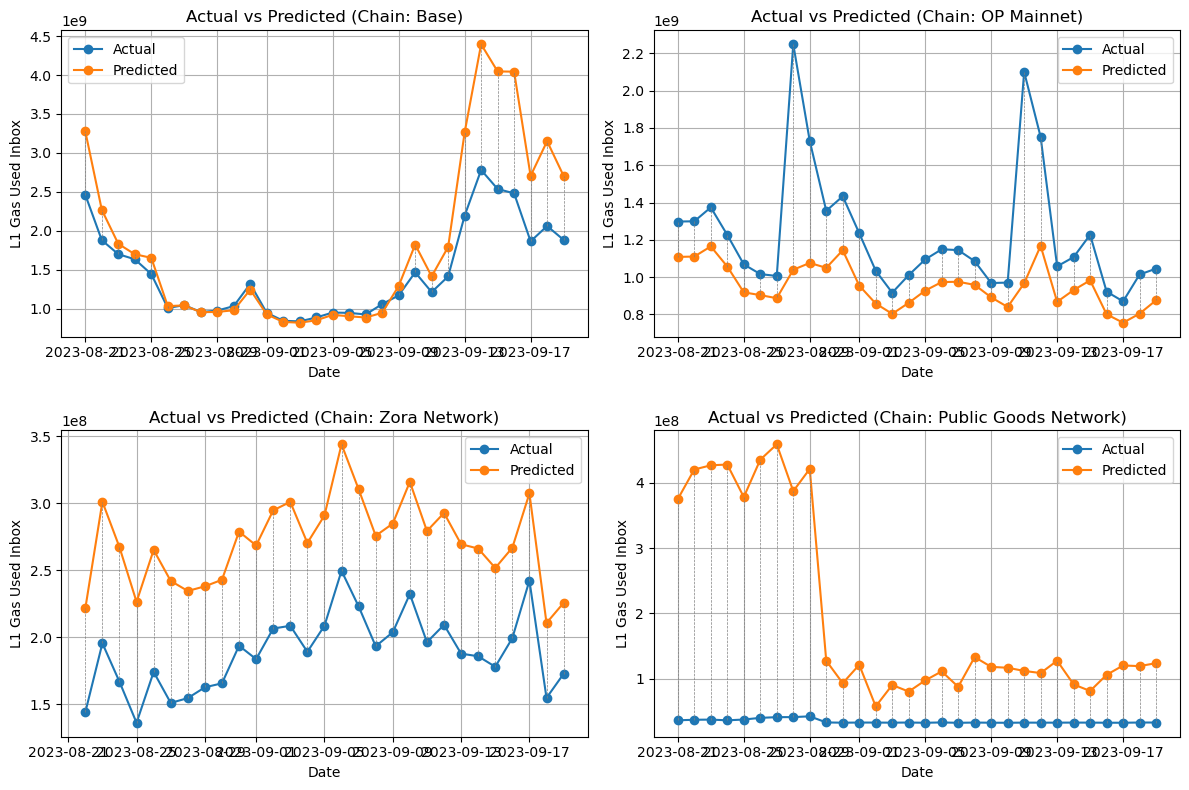

In [179]:
import matplotlib.pyplot as plt
# Setting up the plot
plt.figure(figsize=(12, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain
    chain_data = recent_30_days_data[recent_30_days_data['chain'] == chain]
    
    # Making predictions using the new model
    chain_data['predicted_l1_gas_used_inbox_new'] = linear_regressor.predict(chain_data[features])
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_new'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox_new'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain})')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


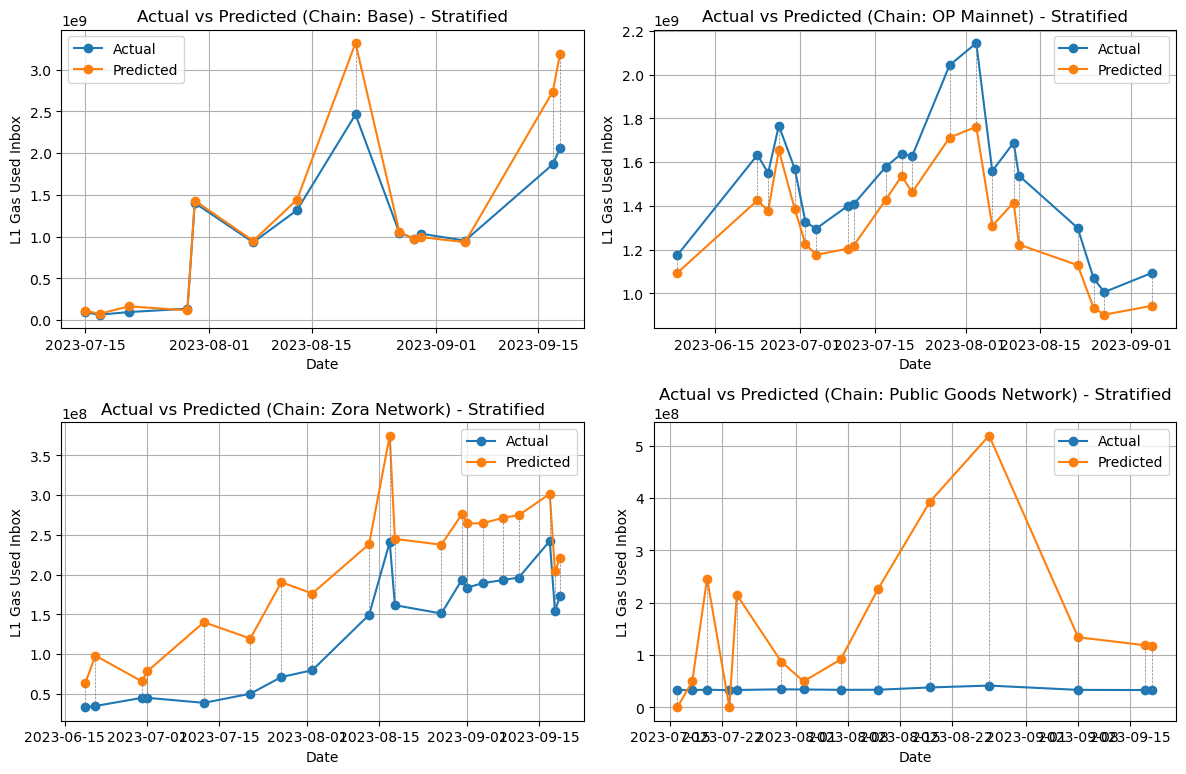

In [180]:
#Stratify sampling

from sklearn.model_selection import StratifiedShuffleSplit

# Resetting the index of new_data before performing stratified sampling
new_data.reset_index(drop=True, inplace=True)

# Defining the stratified shuffle split object to split the data into training and testing sets with stratification on the 'chain' column
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# Splitting the data into training and testing sets using stratified sampling
for train_index, test_index in stratified_split.split(new_data, new_data['chain']):
    stratified_train_data = new_data.loc[train_index]
    stratified_test_data = new_data.loc[test_index]

# Training the linear regression model using the stratified training set
X_train_stratified = stratified_train_data[features]
y_train_stratified = stratified_train_data['l1_gas_used_inbox']
X_test_stratified = stratified_test_data[features]
y_test_stratified = stratified_test_data['l1_gas_used_inbox']

linear_regressor_stratified = LinearRegression()
linear_regressor_stratified.fit(X_train_stratified, y_train_stratified)

# Predicting the target variable on the stratified testing set
stratified_test_data['predicted_l1_gas_used_inbox'] = linear_regressor_stratified.predict(X_test_stratified)

# Setting up the plot for visualization of residuals for each chain
plt.figure(figsize=(12, 8))

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain and sorting it by date for a connected line plot
    chain_data = stratified_test_data[stratified_test_data['chain'] == chain].sort_values(by='dt')
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain}) - Stratified')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [181]:

# Step 5: Model Evaluation - Evaluating the model on the testing set
y_pred_stratified = linear_regressor_stratified.predict(X_test_stratified)

# Calculate the model performance
mse_linear = mean_squared_error(y_test_stratified, y_pred_stratified)
r2_linear = r2_score(y_test_stratified, y_pred_stratified)

mse_linear, r2_linear


(6.2024460160388504e+16, 0.8839108560643281)

In [182]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor_stratified.intercept_
coefficients = linear_regressor_stratified.coef_

# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(146196.76840376854,
 {'calldata_bytes_per_user_tx': 771760.9228775532,
  'calldata_gas_per_user_tx': -51467.971999424815,
  'l2_num_txs_per_day': 2403.4675676618062})

In [183]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# Step 1: Create second-degree polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(new_data[features])

# Step 2: Train a linear regression model using the polynomial features
poly_lr = LinearRegression()
poly_lr.fit(X_poly, new_data['l1_gas_used_inbox'])

# Step 3: Make predictions using the polynomial features
new_data['predicted_l1_gas_used_inbox_poly'] = poly_lr.predict(X_poly)

# Step 4: Evaluate the model using suitable metrics
mse_poly = mean_squared_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
mae_poly = mean_absolute_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
r2_poly = r2_score(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])

mse_poly, mae_poly, r2_poly


(2067274076974169.2, 25184350.263833586, 0.9966886075057775)

In [184]:
# Get feature names
feature_names = poly.get_feature_names_out(input_features=features)

# Get the coefficients and intercept of the model
coef = poly_lr.coef_
intercept = poly_lr.intercept_

# Print out the model
print("Polynomial regression model:")
print("")
print(f"Intercept: {intercept}")
for i in range(len(coef)):
    print(f"{feature_names[i]}: {coef[i]}")

print("")
print("^ Input this output in to GPT to generate a python / google sheets apps script function")
print("Note: This seems like the best, lets yolo use it")

Polynomial regression model:

Intercept: 4145309.2682870626
calldata_bytes_per_user_tx: 257727.5984045912
calldata_gas_per_user_tx: -16541.276815960242
l2_num_txs_per_day: 1374.218370443091
calldata_bytes_per_user_tx^2: -334.3839832741598
calldata_bytes_per_user_tx calldata_gas_per_user_tx: 41.15368155043923
calldata_bytes_per_user_tx l2_num_txs_per_day: -6.585431652839822
calldata_gas_per_user_tx^2: -1.2584537085652414
calldata_gas_per_user_tx l2_num_txs_per_day: 1.3961904217608776
l2_num_txs_per_day^2: -0.00024236720855697058

^ Input this output in to GPT to generate a python / google sheets apps script function


In [185]:
# # Get averages
# print(features)
# columns_to_average = features + ['l2_gas_used_per_user_tx']
# display(new_data.groupby('chain')[columns_to_average].mean())

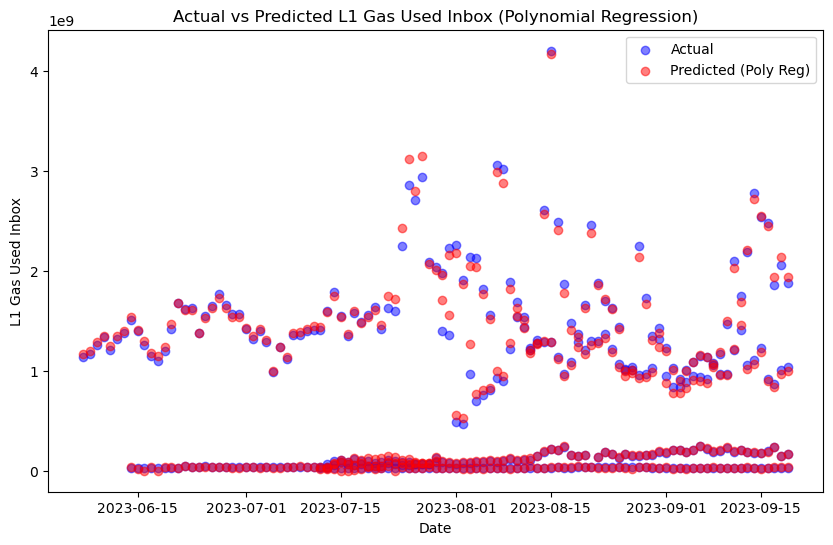

In [186]:
# Visualizing the actual vs predicted values for the model with polynomial features
plt.figure(figsize=(10, 6))

# Plotting the actual values
plt.scatter(new_data['dt'], new_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')

# Plotting the predicted values from the polynomial regression model
plt.scatter(new_data['dt'], new_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')

# Labeling the axes and setting the title
plt.xlabel('Date')
plt.ylabel('L1 Gas Used Inbox')
plt.title('Actual vs Predicted L1 Gas Used Inbox (Polynomial Regression)')

# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()


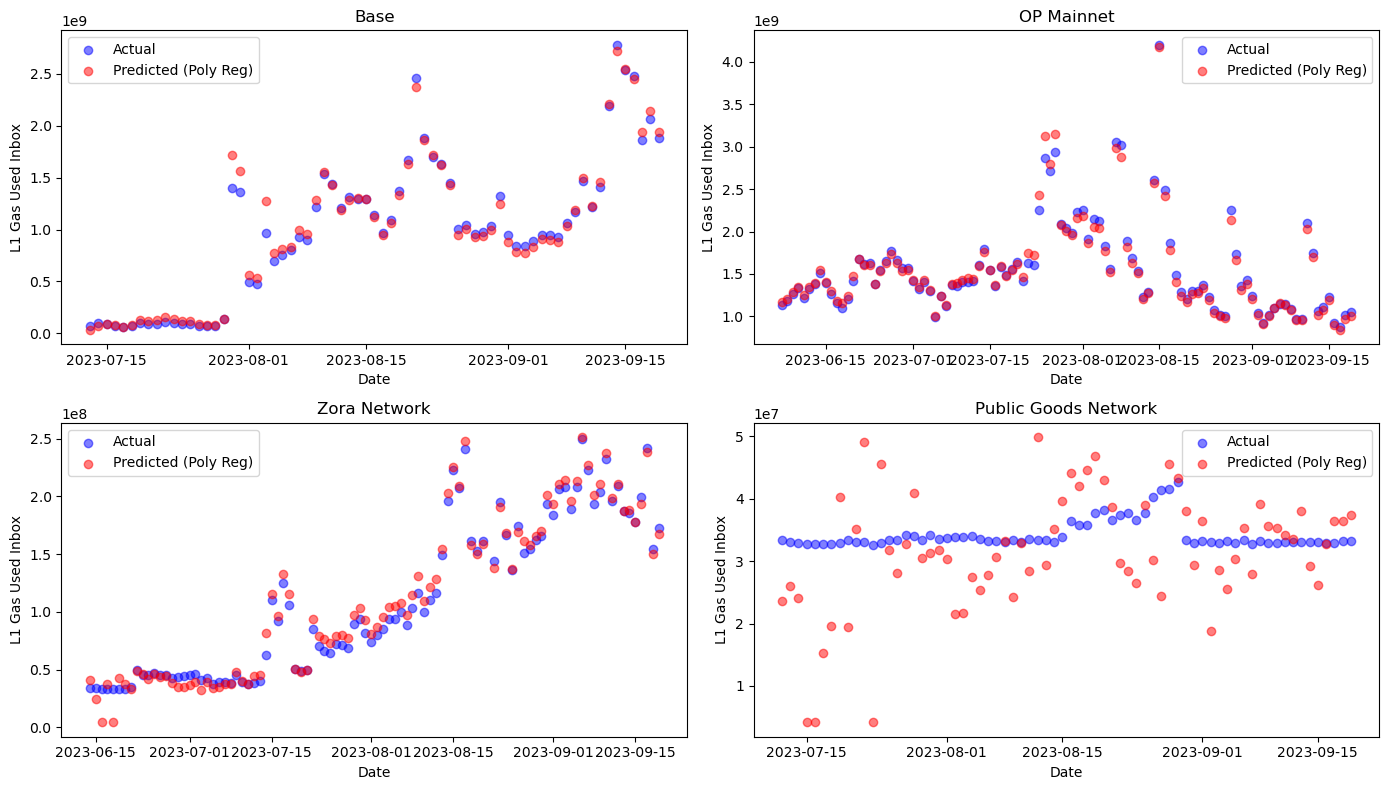

In [187]:
# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Plotting the actual and predicted values for each chain in separate subplots
for i, chain in enumerate(chains, 1):
    plt.subplot(2, 2, i)
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Plotting the actual values
    plt.scatter(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')
    
    # Setting the title to the current chain
    plt.title(chain)
    
    # Labeling the axes
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [189]:
#Linear Interactions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming new_data and features are defined
# features should be a list of column names that you want to use as features

X = new_data[features]
y = new_data['l1_gas_used_inbox']

# Create interaction features without polynomial terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Train a linear regression model using the interaction features
poly_lr = LinearRegression()
poly_lr.fit(X_poly, y)

# Print the coefficients (intercept and slopes)
print('Intercept:', poly_lr.intercept_)
for i, coef in enumerate(poly_lr.coef_):
    print(f'Coefficient for {poly.get_feature_names_out(X.columns)[i]}: {coef}')

# Predict the target variable using the trained model
y_pred = poly_lr.predict(X_poly)

# Evaluate the model using R-squared
print('R-squared:', r2_score(y, y_pred))


Intercept: 53825334.80018985
Coefficient for calldata_bytes_per_user_tx: -11168.20540076391
Coefficient for calldata_gas_per_user_tx: -512.9750166166924
Coefficient for l2_num_txs_per_day: 954.3709457888435
Coefficient for calldata_bytes_per_user_tx calldata_gas_per_user_tx: 0.19354195726904777
Coefficient for calldata_bytes_per_user_tx l2_num_txs_per_day: -5.680657924300654
Coefficient for calldata_gas_per_user_tx l2_num_txs_per_day: 1.3607435285318843
R-squared: 0.9951152088048112
